In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
HOUSING_PATH = os.path.join("datasets", "housing")


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

# Exploring the dataset 

Each row in the data set represents a district.

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Note below that there are 20640 entries in the data set. However, feature ``total_bedrooms`` has only 20433 nonnull entries.
This means that some districts miss this feature.

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


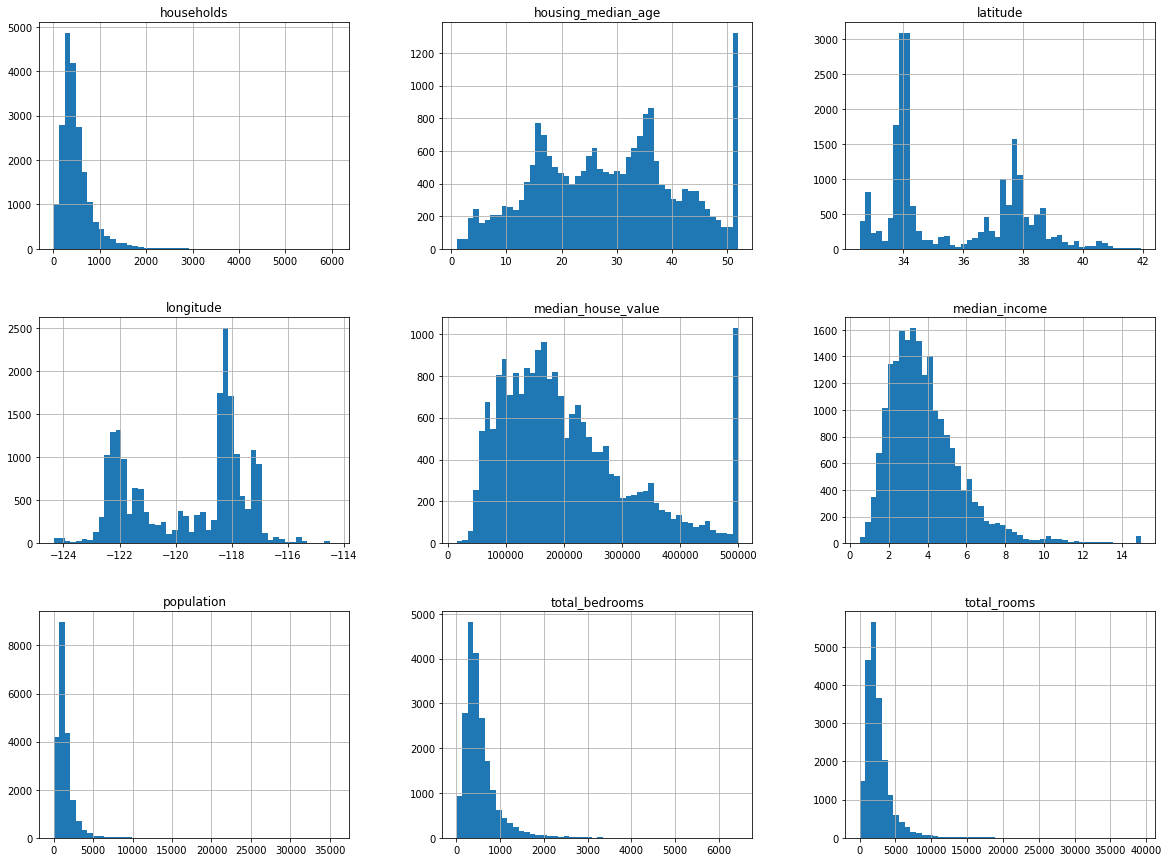

In [7]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Train-Test split

We need to set some data aside for testing and some for training. This is important to evaluate how well the model generalizes to unseen data.

In [8]:
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## A note on representativeness

When training the data, it's not always a good a idea to just apply random sampling. Sample data must be representative to the population to avoid bias.
Therefore, you must consider _stratified sampling_. This means that your sample has different representative subgroups called _strata_.

Let's use `StratifiedShuffleSplit` to create another test dataset and compare it with the random sampling (i.e., plain `train_test_split`).

First, let's create an income category to identifiy our stratas:

In [9]:
housing["income_category"] = pd.cut(housing.median_income,
                                    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                    labels=[1, 2, 3, 4, 5])

Now, we use the newly created ``income_category`` with ``StratifiedShuffleSplit`` to split the data in the same proportion of the dataset, therefore, making a "representative" train-test split.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.income_category):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's check the distribution of median income:

In [11]:
housing.median_income.describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [12]:
train_set.median_income.describe()

count    16512.000000
mean         3.880754
std          1.904294
min          0.499900
25%          2.566700
50%          3.545800
75%          4.773175
max         15.000100
Name: median_income, dtype: float64

In [13]:
strat_train_set.median_income.describe()

count    16512.000000
mean         3.875589
std          1.904950
min          0.499900
25%          2.566775
50%          3.540900
75%          4.744475
max         15.000100
Name: median_income, dtype: float64

Removing the temporary `income_category` feature...

In [14]:
for df in (strat_train_set, strat_test_set):
    df.drop("income_category", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [15]:
# Avoiding undesired side-effects...
housing = strat_train_set.copy()

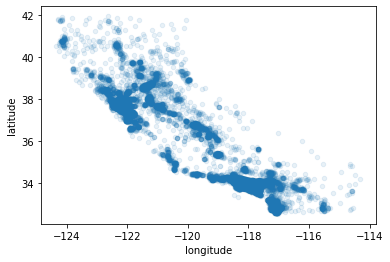

In [16]:
# alpha helps to visualize the density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

Checking median house values

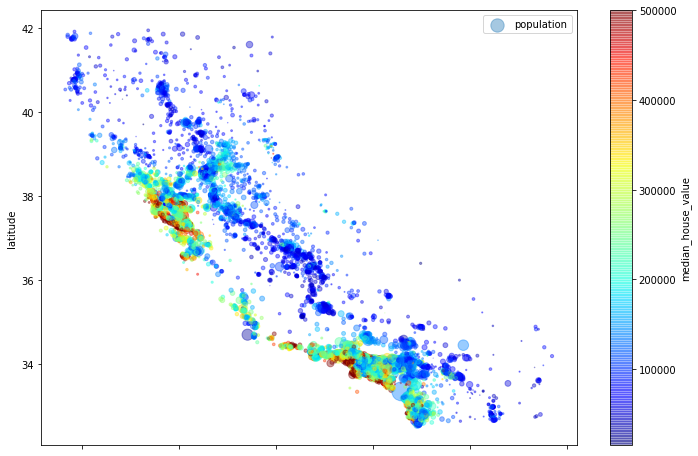

In [17]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing.population/100, label="population", figsize=(12, 8),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

## Exploring linear correlations

On the previous two figures, we see that prices and population density **seems** correlated (...please, never fall into the trap of "eye-balling" statistics).
Let's explore some correlations using the _standard correlation coefficient_ (aka Pearson's r) between pairs of features:

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to explore correlations is to use a _scatter matrix_ where we can contrast each feature:

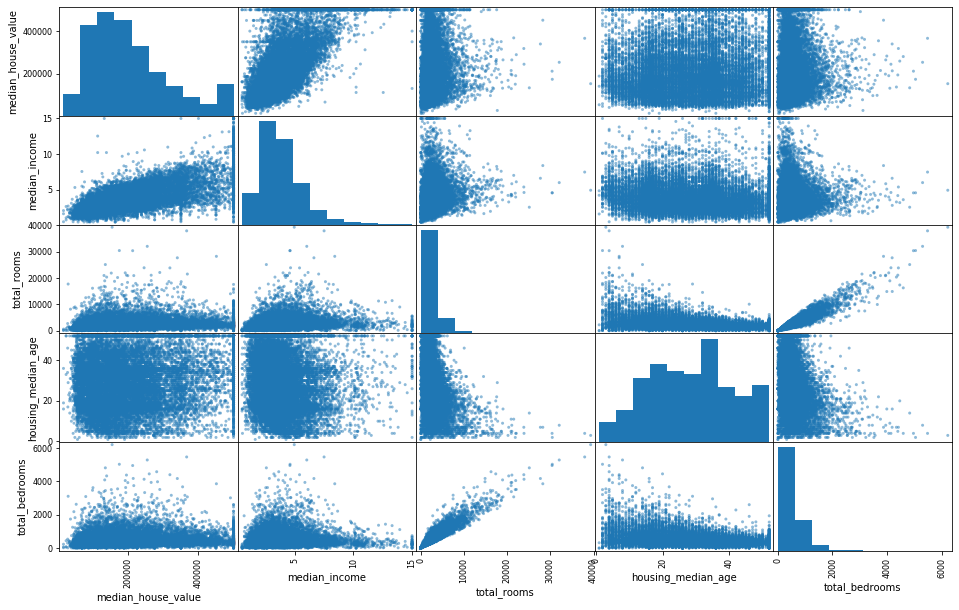

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "total_bedrooms"]
scatter_matrix(housing[attributes], figsize=(16,10))
plt.show()

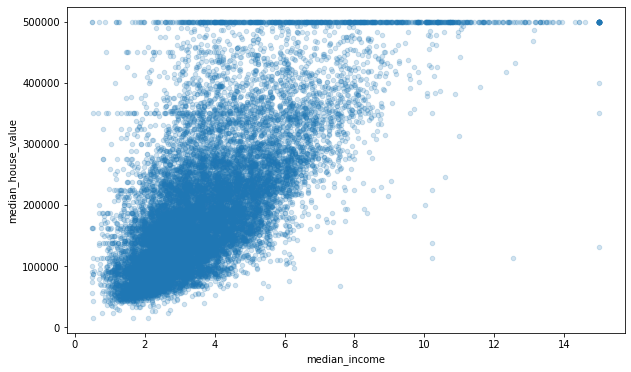

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.2, figsize=(10,6))
plt.show()

### Exploring some feature engineering

In [22]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

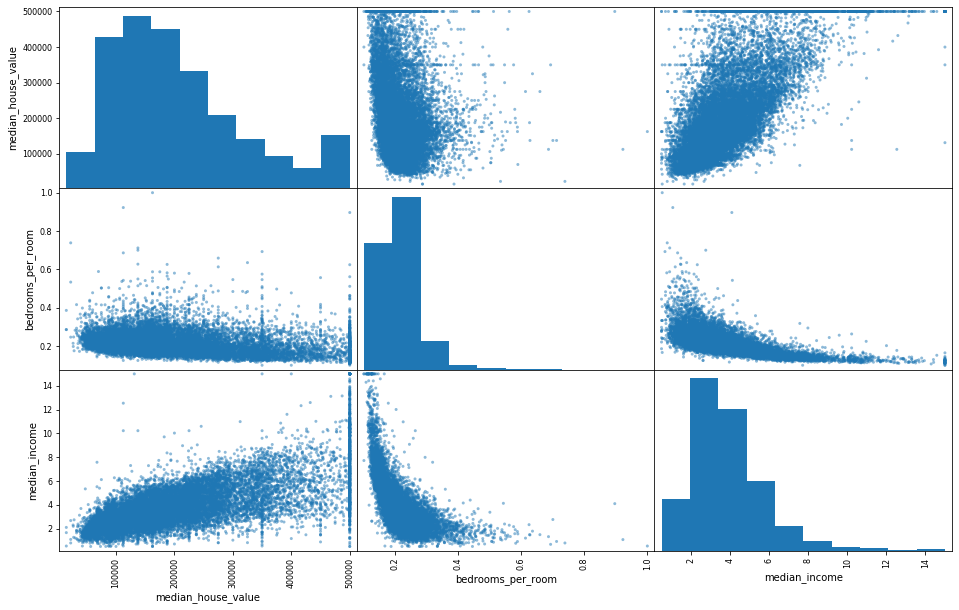

In [23]:
scatter_matrix(housing[["median_house_value", "bedrooms_per_room", "median_income"]], figsize=(16,10))
plt.show()

In [24]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
bedrooms_per_room    -0.259984
Name: median_house_value, dtype: float64

# Data Preparation for Machine Learning

We explored the data to get some initial insights and analyzed some characteristics of the dataset.
Before working on the Machine Learning model, let's do some cleanup and data preparation.

First, separate labels and the training set:

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning
 
Now it's time to handle missing values. We can either get rid of features with missing values, replace missing values by some value (e.g., zero, mean, median), or remove the training examples with those improper values.
 
Scikit-learn has the utility class `SimpleImputer` to handle missing values!

In [28]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# drops non-numerical features to use the imputer
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [29]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

The Imputer computed the statistics for the numerical attributes. Now we can update our training examples by filling the gaps:

In [33]:
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Dealing with categorical data

It's preferable to handle categorical data as numeric. Therefore, we can encode categories from textual attribute:

In [42]:
housing_cat = housing["ocean_proximity"]
housing_cat.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [57]:
from sklearn.preprocessing import OneHotEncoder

enconder = OneHotEncoder()
enconding = enconder.fit_transform(housing[["ocean_proximity"]])

* Food for thought: Why not using `OrdinalEncoder`? Think about it and elaborate your thoughts...

In [59]:
enconding.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [60]:
enconder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [61]:
housing.ocean_proximity[:3]

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
Name: ocean_proximity, dtype: object

### Using custom transformers

You can implement custom transformers to do feature engineering.
This is important for two reasons:

1. Automate data transformation
2. Enable the usage of hyperparameters (i.e., "meta" parameters from the model) and let ML algorithms decide wheater a given feature is useful or not

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)